<a href="https://colab.research.google.com/github/Kryptera-K/MPWR-Laguerre-RSI-Volume-Confirmation-Strategy/blob/main/MPWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "MPWR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("MPWR_clean.csv", index=False)
df

/tmp/ipython-input-520708778.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2004-11-19,8.438513,8.515694,7.289366,7.769607,3906200
2004-11-22,8.249848,9.433299,8.155516,8.489968,728000
2004-11-23,8.044036,8.361338,7.512341,8.146945,505800
2004-11-24,8.387060,8.575726,8.146940,8.146940,319500
2004-11-26,8.404212,8.532848,7.932547,7.975426,65600
...,...,...,...,...,...
2025-11-03,1003.929993,1040.390015,984.750000,1030.000000,828000
2025-11-04,957.869995,976.909973,953.090027,966.119995,866100
2025-11-05,1000.150024,1014.989990,956.679993,961.039978,697100


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

LRSI_GAMMA = 0.5
LRSI_LEVEL = 0.5
MOMENTUM_LEVEL = 100
MOMENTUM_PERIOD = 10
SMA_PERIOD = 20
SMA_SHIFT = 5
VOLUME_SHIFT = 10

# -------------------------
# Indicator Functions
# -------------------------

def volume_is_rising(df, shift=VOLUME_SHIFT):
    return df['Volume'] > df['Volume'].shift(shift)


def momentum_lower_than_level(df, level=MOMENTUM_LEVEL, period=MOMENTUM_PERIOD):
    df = calculate_momentum(df, period)
    return df["Momentum"] < level


def calculate_momentum(df, period=MOMENTUM_PERIOD):
    """
    Classic momentum: current close / close n periods ago * 100
    """
    df = df.copy()
    df["Momentum"] = df["Close"] / df["Close"].shift(period) * 100
    return df


def close_below_sma(df, period=SMA_PERIOD):
    df = calculate_sma(df, period)
    return df['Close'] < df['SMA']


def calculate_sma(df, period=SMA_PERIOD):
    """
    Calculate Simple Moving Average (SMA) of the Close price.
    """
    df = df.copy()
    df['SMA'] = df['Close'].rolling(window=period).mean()
    return df


def laguerre_rsi_rising(df, gamma=LRSI_GAMMA):
    df = df.copy()
    df['LRsi'] = calculate_laguerre_rsi(df['Close'], gamma)
    return df['LRsi'] > df['LRsi'].shift(1)


def calculate_laguerre_rsi(series, gamma=LRSI_GAMMA):
    """
    Calculate Laguerre RSI for a pandas Series of close prices.
    Returns a pandas Series of Laguerre RSI values.
    """
    L0 = L1 = L2 = L3 = 0
    lrsi = []

    for price in series:
        L0 = (1 - gamma) * price + gamma * L0
        L1 = -gamma * L0 + L0 + gamma * L1
        L2 = -gamma * L1 + L1 + gamma * L2
        L3 = -gamma * L2 + L2 + gamma * L3

        CU = max(L0 - L1, 0) + max(L1 - L2, 0) + max(L2 - L3, 0)
        CD = max(L1 - L0, 0) + max(L2 - L1, 0) + max(L3 - L2, 0)

        lrsi.append(CU / (CU + CD) if (CU + CD) != 0 else 0)

    return pd.Series(lrsi, index=series.index)



# -------------------------
# Entry conditions
# -------------------------

df["Volume_Rising"] = volume_is_rising(df)
df["Momentum_Lower_Than_Level"] = momentum_lower_than_level(df)

# -------------------------
# Exit conditions
# -------------------------

df["SMA_Close_Below"] = close_below_sma(df)
df["LRsi_Rising"] = laguerre_rsi_rising(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Volume_Rising',
    'Momentum_Lower_Than_Level',
]
exit_conditions = [
    'SMA_Close_Below',
    'LRsi_Rising',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2004-11-19 00:00:00
End                                  2025-11-07 00:00:00
Period                                5276 days 00:00:00
Start Value                                     100000.0
End Value                                 18831713.99642
Total Return [%]                            18731.713996
Benchmark Return [%]                        12049.907402
Max Gross Exposure [%]                             100.0
Total Fees Paid                            552034.242594
Max Drawdown [%]                                60.92144
Max Drawdown Duration                  855 days 00:00:00
Total Trades                                         108
Total Closed Trades                                  107
Total Open Trades                                      1
Open Trade PnL                            4493116.697443
Win Rate [%]                                   55.140187
Best Trade [%]                                127.764039
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2004-11-19 00:00:00
End                           2025-11-07 00:00:00
Period                         5276 days 00:00:00
Start Value                              100000.0
End Value                          12149907.40233
Total Return [%]                     12049.907402
Benchmark Return [%]                 12049.907402
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        72.679872
Max Drawdown Duration          1255 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     12049907.40233
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


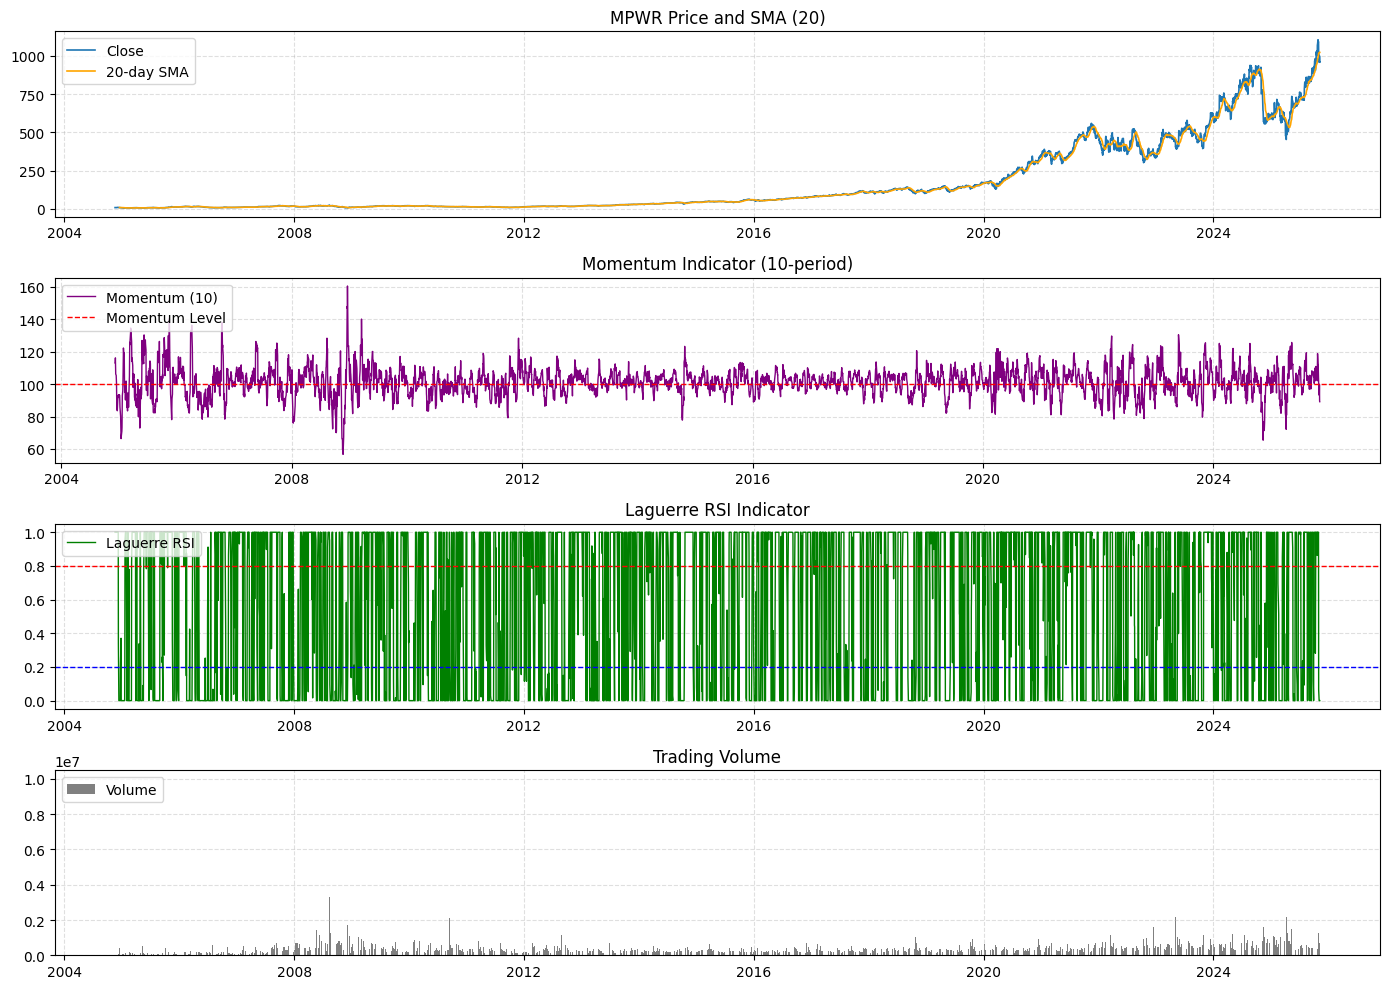

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Calculate Indicators
# -------------------------

# SMA
df = calculate_sma(df, SMA_PERIOD)

# Momentum
df = calculate_momentum(df, MOMENTUM_PERIOD)

# Laguerre RSI
df['LRsi'] = calculate_laguerre_rsi(df['Close'], LRSI_GAMMA)

# -------------------------
# Plot Indicators
# -------------------------

plt.figure(figsize=(14, 10))

# --- 1. Price with SMA ---
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Close'], label='Close', linewidth=1.2)
plt.plot(df.index, df['SMA'], label=f'{SMA_PERIOD}-day SMA', color='orange', linewidth=1.2)
plt.title(f"{symbol} Price and SMA ({SMA_PERIOD})")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)

# --- 2. Momentum ---
plt.subplot(4, 1, 2)
plt.plot(df.index, df['Momentum'], label=f'Momentum ({MOMENTUM_PERIOD})', color='purple', linewidth=1)
plt.axhline(MOMENTUM_LEVEL, color='red', linestyle='--', linewidth=1, label='Momentum Level')
plt.title(f"Momentum Indicator ({MOMENTUM_PERIOD}-period)")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)

# --- 3. Laguerre RSI ---
plt.subplot(4, 1, 3)
plt.plot(df.index, df['LRsi'], label='Laguerre RSI', color='green', linewidth=1)
plt.axhline(0.8, color='red', linestyle='--', linewidth=1)
plt.axhline(0.2, color='blue', linestyle='--', linewidth=1)
plt.title("Laguerre RSI Indicator")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)

# --- 4. Volume ---
plt.subplot(4, 1, 4)
plt.bar(df.index, df['Volume'], color='gray', label='Volume')
plt.title("Trading Volume")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()
